In [1]:
!/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade --ignore-installed --force-reinstall https://s3-us-west-2.amazonaws.com/move-dl-common-binary-distrubution/python/move_dl_common_api-3.2.131-release.tar.gz
!pip install pyarrow
!pip install dask
#Clean up previous tables
#!aws s3 rm --recursive s3://datascience-workspace-dev/buyer-intent/user_interactions/tables
#!aws s3 rm --recursive s3://datascience-workspace-dev/buyer-intent/user_interactions_stage/tables
from move_dl_common_api.athena_util import AthenaUtil
from datetime import datetime
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from datetime import datetime
import pyarrow.parquet as pq
import dask.dataframe as dd
import s3fs
import multiprocessing
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot
s3 = s3fs.S3FileSystem()

  Using cached https://s3-us-west-2.amazonaws.com/move-dl-common-binary-distrubution/python/move_dl_common_api-3.2.131-release.tar.gz
  Using cached https://files.pythonhosted.org/packages/41/dc/68f39fcba61ae642579aca134e2b1139cea4e10341c96772e05c4b0fa727/boto3-1.9.217-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/16/8a/1fc3dba0c4923c2a76e1ff0d52b305c44606da63f718d14d3231e21c51b0/s3transfer-0.2.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/86/79/b4a87f7b177a65dbe5029201fc9d3901e33c2b5f925452ba1cc1fbfff652/botocore-1.12.217-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/83/94/7179c3832a6d45b266ddb2aac329e101367fbdb11f425f13771d27f225bb/jmespath-0.9.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e6/60/247f

In [2]:
# I try to do join on CAP and LEAD for initial data set
# The join condition is based on snap_shot_time
s3_path = 's3://datascience-workspace-dev/buyer-intent/user_interactions'
util = AthenaUtil(s3_staging_folder = s3_path)
# Time to take snap shot
time_stamp = "20190620"

# Drop table if exists
ctas_query_drop_cap_007_timestamp = """DROP TABLE buyer_intent_user_interactions.biui_qa_cap_summary_t007_{};""".format(time_stamp)
util.execute_query(sql_query = ctas_query_drop_cap_007_timestamp)

# Creat Table Again
ctas_query_cap_007_timestamp="""CREATE TABLE buyer_intent_user_interactions.biui_qa_cap_summary_t007_{}
WITH ( format='PARQUET' ) AS
SELECT *
FROM buyer_intent_user_interactions.biui_qa_consumer_analytical_profile_summary_t007
WHERE snapshot_date_mst_yyyymmdd = '{}';""".format(time_stamp,
                                                   time_stamp)

util.execute_query(sql_query = ctas_query_cap_007_timestamp)

2019-08-27 21:33:11.929 INFO athena_util.py.111 - Read config from default schema
2019-08-27 21:33:11.930 INFO athena_util.py.114 - Schema fetched from default config file:
2019-08-27 21:33:11.930 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-27 21:33:12.002 INFO athena_util.py.462 - 2019-08-27 21:33:12.002820
2019-08-27 21:33:13.549 INFO athena_util.py.464 - 2019-08-27 21:33:13.549333
2019-08-27 21:33:13.610 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-27 21:33:13.657 INFO athena_util.py.462 - 2019-08-27 21:33:13.657785
2019-08-27 21:33:21.400 INFO athena_util.py.464 - 2019-08-27 21:33:21.400736


{'UpdateCount': 104518,
 'ResultSet': {'Rows': [],
  'ResultSetMetadata': {'ColumnInfo': [{'CatalogName': 'hive',
     'SchemaName': '',
     'TableName': '',
     'Name': 'rows',
     'Label': 'rows',
     'Type': 'bigint',
     'Precision': 19,
     'Scale': 0,
     'Nullable': 'UNKNOWN',
     'CaseSensitive': False}]}},
 'ResponseMetadata': {'RequestId': 'b3185495-5aed-4c59-9f0e-e696d7daf195',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 27 Aug 2019 21:33:21 GMT',
   'x-amzn-requestid': 'b3185495-5aed-4c59-9f0e-e696d7daf195',
   'content-length': None,
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [3]:
# Drop table if exists
ctas_query_drop_cap_lead_007_timestamp = """DROP TABLE buyer_intent_user_interactions.biui_qa_cap_lead_summary_t007_{};""".format(time_stamp)
util.execute_query(sql_query = ctas_query_drop_cap_lead_007_timestamp)

ctas_query_cap_lead_007_timestamp="""CREATE TABLE buyer_intent_user_interactions.biui_qa_cap_lead_summary_t007_{}
WITH ( format='PARQUET' ) AS
SELECT *
FROM buyer_intent_user_interactions.biui_qa_consumer_analytical_profile_leads_t007
WHERE snapshot_date_mst_yyyymmdd = '{}';""".format(time_stamp,time_stamp)

util.execute_query(sql_query = ctas_query_cap_lead_007_timestamp)

2019-08-27 21:33:21.466 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-27 21:33:21.527 INFO athena_util.py.462 - 2019-08-27 21:33:21.527551
2019-08-27 21:33:23.614 INFO athena_util.py.464 - 2019-08-27 21:33:23.614404
2019-08-27 21:33:23.687 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-27 21:33:23.745 INFO athena_util.py.462 - 2019-08-27 21:33:23.745662
2019-08-27 21:33:28.421 INFO athena_util.py.464 - 2019-08-27 21:33:28.421397


{'UpdateCount': 7430,
 'ResultSet': {'Rows': [],
  'ResultSetMetadata': {'ColumnInfo': [{'CatalogName': 'hive',
     'SchemaName': '',
     'TableName': '',
     'Name': 'rows',
     'Label': 'rows',
     'Type': 'bigint',
     'Precision': 19,
     'Scale': 0,
     'Nullable': 'UNKNOWN',
     'CaseSensitive': False}]}},
 'ResponseMetadata': {'RequestId': '985c46e2-d7f2-4642-b96b-8e171bf6372e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 27 Aug 2019 21:33:27 GMT',
   'x-amzn-requestid': '985c46e2-d7f2-4642-b96b-8e171bf6372e',
   'content-length': None,
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [4]:
s3_path = 's3://datascience-workspace-dev/buyer-intent/user_interactions_stage'
util = AthenaUtil(s3_staging_folder = s3_path)

2019-08-27 21:33:28.497 INFO athena_util.py.111 - Read config from default schema
2019-08-27 21:33:28.498 INFO athena_util.py.114 - Schema fetched from default config file:


In [5]:
param_dict = {
    's3_path': 's3://datascience-workspace-dev/buyer-intent/user_interactions_stage/tables',
     #this time could be changed
    'snap_shot_date':time_stamp,
    'cap_summary_time_filtered':'biui_qa_cap_summary_t007',
    'caplead_summary_time_filtered':'biui_qa_cap_lead_summary_t007'
}

In [6]:
ctas_drop_cap_lead_trans = """DROP TABLE buyer_intent_user_interactions_stage.cap_lead_trans_007_{};""".format(time_stamp)
util.execute_query(sql_query = ctas_drop_cap_lead_trans)

ctas_create_cap_lead_trans = """CREATE TABLE buyer_intent_user_interactions_stage.cap_lead_trans_007_{snap_shot_date} WITH (
external_location = '{s3_path}/cap_lead_trans_007_{snap_shot_date}',
format='PARQUET'
) AS
SELECT
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.member_id,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_saved_listings,
-- Search behaviour of the user
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_searches,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_saved_searches,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_searches,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_searches,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_search_min_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_search_min_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_search_min_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_search_min_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_search_max_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_search_max_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_search_max_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_search_max_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_search_number_of_bedrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_search_number_of_bedrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_search_number_of_bedrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_search_number_of_bedrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_search_number_of_bathrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_search_number_of_bathrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_search_number_of_bathrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_search_number_of_bathrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_srp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_srp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_srp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_srp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_srp_dwell_time_seconds,
-- Exploring different items with more detail interactions
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_ldp_page_views,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_page_views,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_page_views,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_ldp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_ldp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_ldp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_distinct_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_distinct_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_distinct_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_listing_number_of_bath_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_listing_number_of_bed_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_listing_current_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_listing_number_of_bath_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_listing_number_of_bed_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_listing_current_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.standard_deviation_ldp_listing_number_of_bath_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.standard_deviation_ldp_listing_number_of_bed_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.standard_deviation_ldp_listing_current_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_listing_original_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_listing_original_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.standard_deviation_ldp_listing_original_price,
-- Behavior of the user in submitting leads
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_leads_submitted,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.submitted_leads_for_rent,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.submitted_leads_for_sale,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.submitted_leads_not_for_sale,
-- Behaviour for doing transactions
buyer_intent_user_interactions.{caplead_summary_time_filtered}_{snap_shot_date}.consumer_score_probablity_to_transact
FROM buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date} INNER JOIN buyer_intent_user_interactions.{caplead_summary_time_filtered}_{snap_shot_date}
ON buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.member_id = buyer_intent_user_interactions.{caplead_summary_time_filtered}_{snap_shot_date}.member_id
WHERE buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.ldp_dominant_segment = 'for sale';""".format(**param_dict)
util.execute_query(sql_query = ctas_create_cap_lead_trans)

2019-08-27 21:33:28.521 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions_stage
2019-08-27 21:33:28.585 INFO athena_util.py.462 - 2019-08-27 21:33:28.585499
2019-08-27 21:33:30.140 INFO athena_util.py.464 - 2019-08-27 21:33:30.140726
2019-08-27 21:33:30.206 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions_stage
2019-08-27 21:33:30.280 INFO athena_util.py.462 - 2019-08-27 21:33:30.280583
2019-08-27 21:33:34.455 INFO athena_util.py.464 - 2019-08-27 21:33:34.455067


{'UpdateCount': 830,
 'ResultSet': {'Rows': [],
  'ResultSetMetadata': {'ColumnInfo': [{'CatalogName': 'hive',
     'SchemaName': '',
     'TableName': '',
     'Name': 'rows',
     'Label': 'rows',
     'Type': 'bigint',
     'Precision': 19,
     'Scale': 0,
     'Nullable': 'UNKNOWN',
     'CaseSensitive': False}]}},
 'ResponseMetadata': {'RequestId': '6dcc7267-da4a-40cd-b068-a2200ee571ff',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 27 Aug 2019 21:33:34 GMT',
   'x-amzn-requestid': '6dcc7267-da4a-40cd-b068-a2200ee571ff',
   'content-length': None,
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [7]:
s3_data_path = 's3://datascience-workspace-dev/buyer-intent/user_interactions_stage/tables/cap_lead_trans_007_{snap_shot_date}'.format(**param_dict)

In [8]:
df_for_sale_007 = pq.ParquetDataset(s3_data_path, filesystem=s3).read_pandas().to_pandas()
df_for_sale_007.head(5)

,member_id,total_saved_listings,total_searches,total_saved_searches,median_searches,average_searches,median_search_min_price,average_search_min_price,minimum_search_min_price,maximum_search_min_price,...,standard_deviation_ldp_listing_number_of_bed_rooms,standard_deviation_ldp_listing_current_price,median_ldp_listing_original_price,average_ldp_listing_original_price,standard_deviation_ldp_listing_original_price,total_leads_submitted,submitted_leads_for_rent,submitted_leads_for_sale,submitted_leads_not_for_sale,consumer_score_probablity_to_transact
0,5d0aaaad7a7aea47590cb384,1,6,0,6,6.0,NaN,NaN,NaN,NaN,...,1.816590,29223.158625,45000.0,46860.000000,29223.158625,1,1,1,1,0.36
1,59349502d8ad3b9160049c9b,0,9,0,9,9.0,NaN,NaN,NaN,NaN,...,0.816497,32902.114927,99500.0,77325.000000,32902.114927,1,1,1,1,0.44
2,5d08476061bc2dc5890964ed,0,4,0,4,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,76000.0,76000.000000,NaN,2,2,2,2,NaN
3,5d08476061bc2dc5890964ed,0,4,0,4,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,76000.0,76000.000000,NaN,2,2,2,2,NaN
4,5876697991934f0a830000f2,0,41,0,41,41.0,NaN,NaN,NaN,NaN,...,1.069045,595383.696270,10500.0,208399.315789,595383.696270,1,1,1,1,0.51


In [9]:
#Clean up columns and rows if all elements are empty
df_for_sale_007 = df_for_sale_007.dropna(axis = 0, how='all')
df_for_sale_007 = df_for_sale_007.dropna(axis = 1, how='all')

In [10]:
#Clean all colomns with the same value
nunique = df_for_sale_007.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
df_for_sale_007 = df_for_sale_007.drop(cols_to_drop, axis=1)

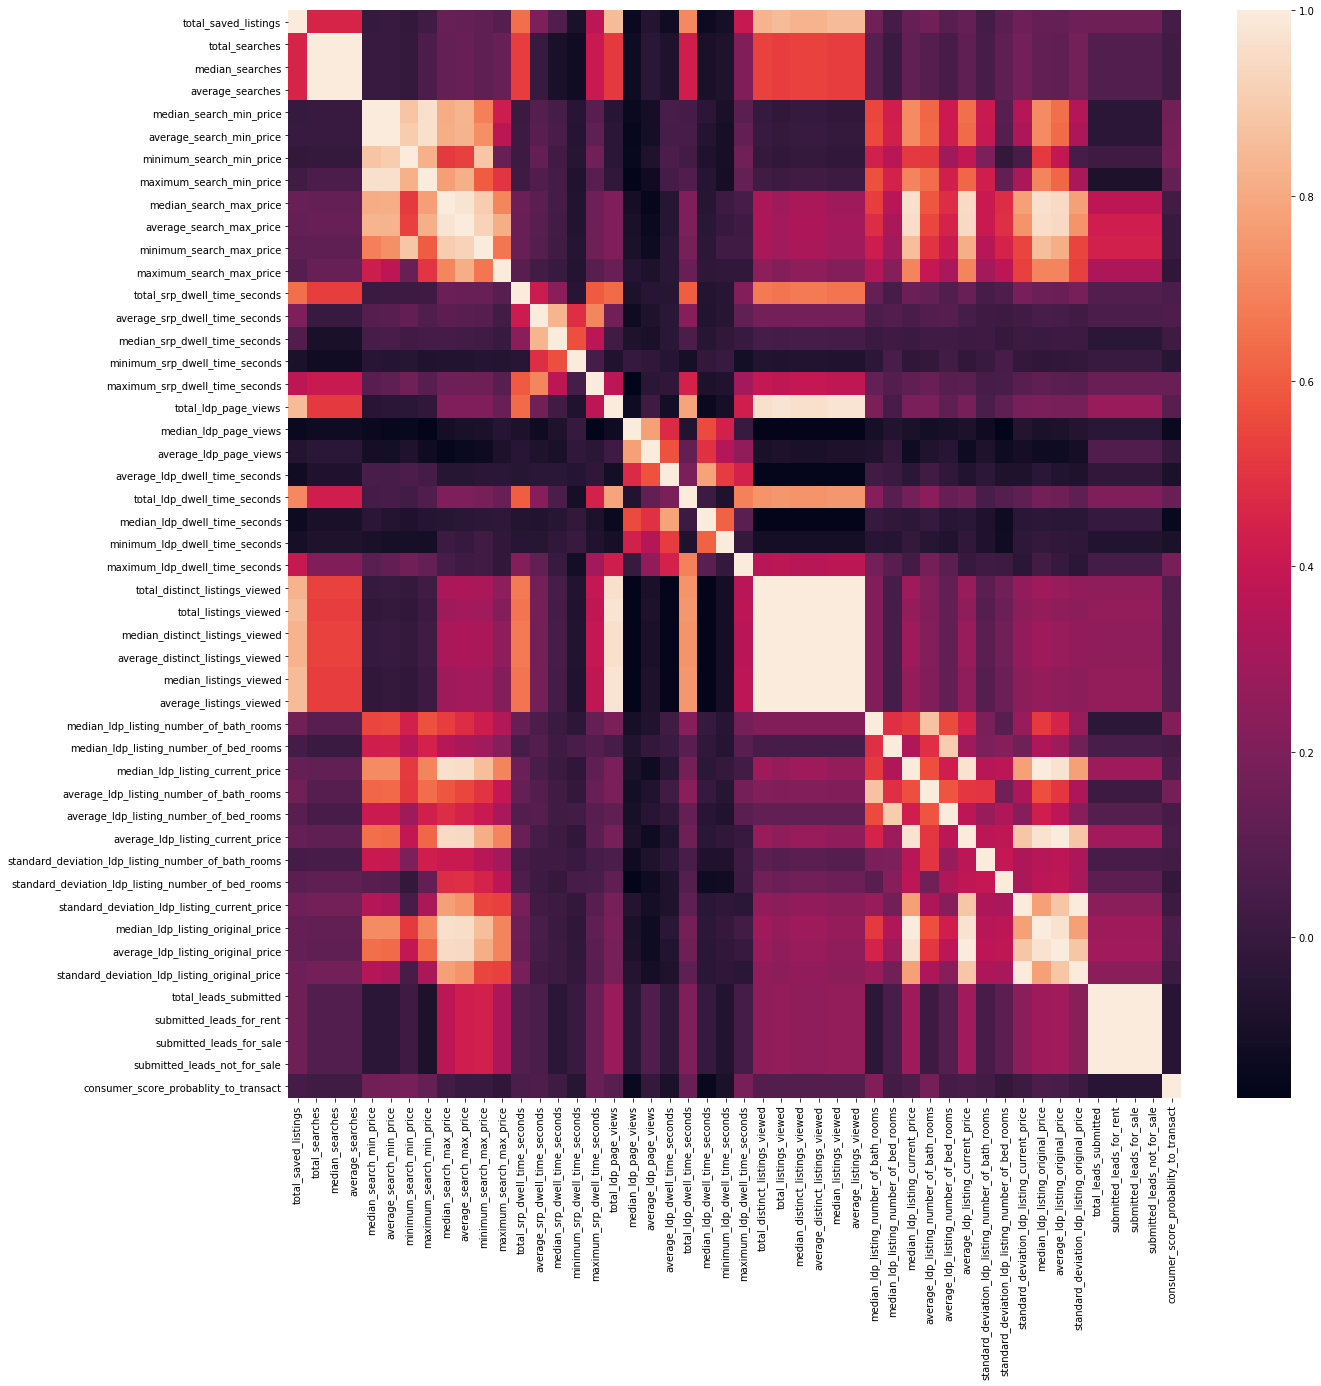

In [11]:
df_for_sale_007_corr = df_for_sale_007.corr()
pyplot.figure(figsize=(20, 20))
sns.heatmap(df_for_sale_007_corr, xticklabels=df_for_sale_007_corr.columns, yticklabels=df_for_sale_007_corr.columns)

In [12]:
df_for_sale_007 = df_for_sale_007.drop(columns = ['total_distinct_listings_viewed','total_listings_viewed','median_distinct_listings_viewed','average_distinct_listings_viewed', 
                                          'median_listings_viewed','average_listings_viewed','submitted_leads_for_rent','submitted_leads_for_sale', 'submitted_leads_not_for_sale'])
df_for_sale_007.head(5)

,member_id,total_saved_listings,total_searches,median_searches,average_searches,median_search_min_price,average_search_min_price,minimum_search_min_price,maximum_search_min_price,median_search_max_price,...,average_ldp_listing_number_of_bed_rooms,average_ldp_listing_current_price,standard_deviation_ldp_listing_number_of_bath_rooms,standard_deviation_ldp_listing_number_of_bed_rooms,standard_deviation_ldp_listing_current_price,median_ldp_listing_original_price,average_ldp_listing_original_price,standard_deviation_ldp_listing_original_price,total_leads_submitted,consumer_score_probablity_to_transact
0,5d0aaaad7a7aea47590cb384,1,6,6,6.0,NaN,NaN,NaN,NaN,NaN,...,2.400000,46860.000000,0.836660,1.816590,29223.158625,45000.0,46860.000000,29223.158625,1,0.36
1,59349502d8ad3b9160049c9b,0,9,9,9.0,NaN,NaN,NaN,NaN,125000.0,...,2.000000,77325.000000,0.500000,0.816497,32902.114927,99500.0,77325.000000,32902.114927,1,0.44
2,5d08476061bc2dc5890964ed,0,4,4,4.0,NaN,NaN,NaN,NaN,300000.0,...,3.000000,76000.000000,NaN,NaN,NaN,76000.0,76000.000000,NaN,2,NaN
3,5d08476061bc2dc5890964ed,0,4,4,4.0,NaN,NaN,NaN,NaN,300000.0,...,3.000000,76000.000000,NaN,NaN,NaN,76000.0,76000.000000,NaN,2,NaN
4,5876697991934f0a830000f2,0,41,41,41.0,NaN,NaN,NaN,NaN,20000.0,...,0.857143,208399.315789,0.548319,1.069045,595383.696270,10500.0,208399.315789,595383.696270,1,0.51


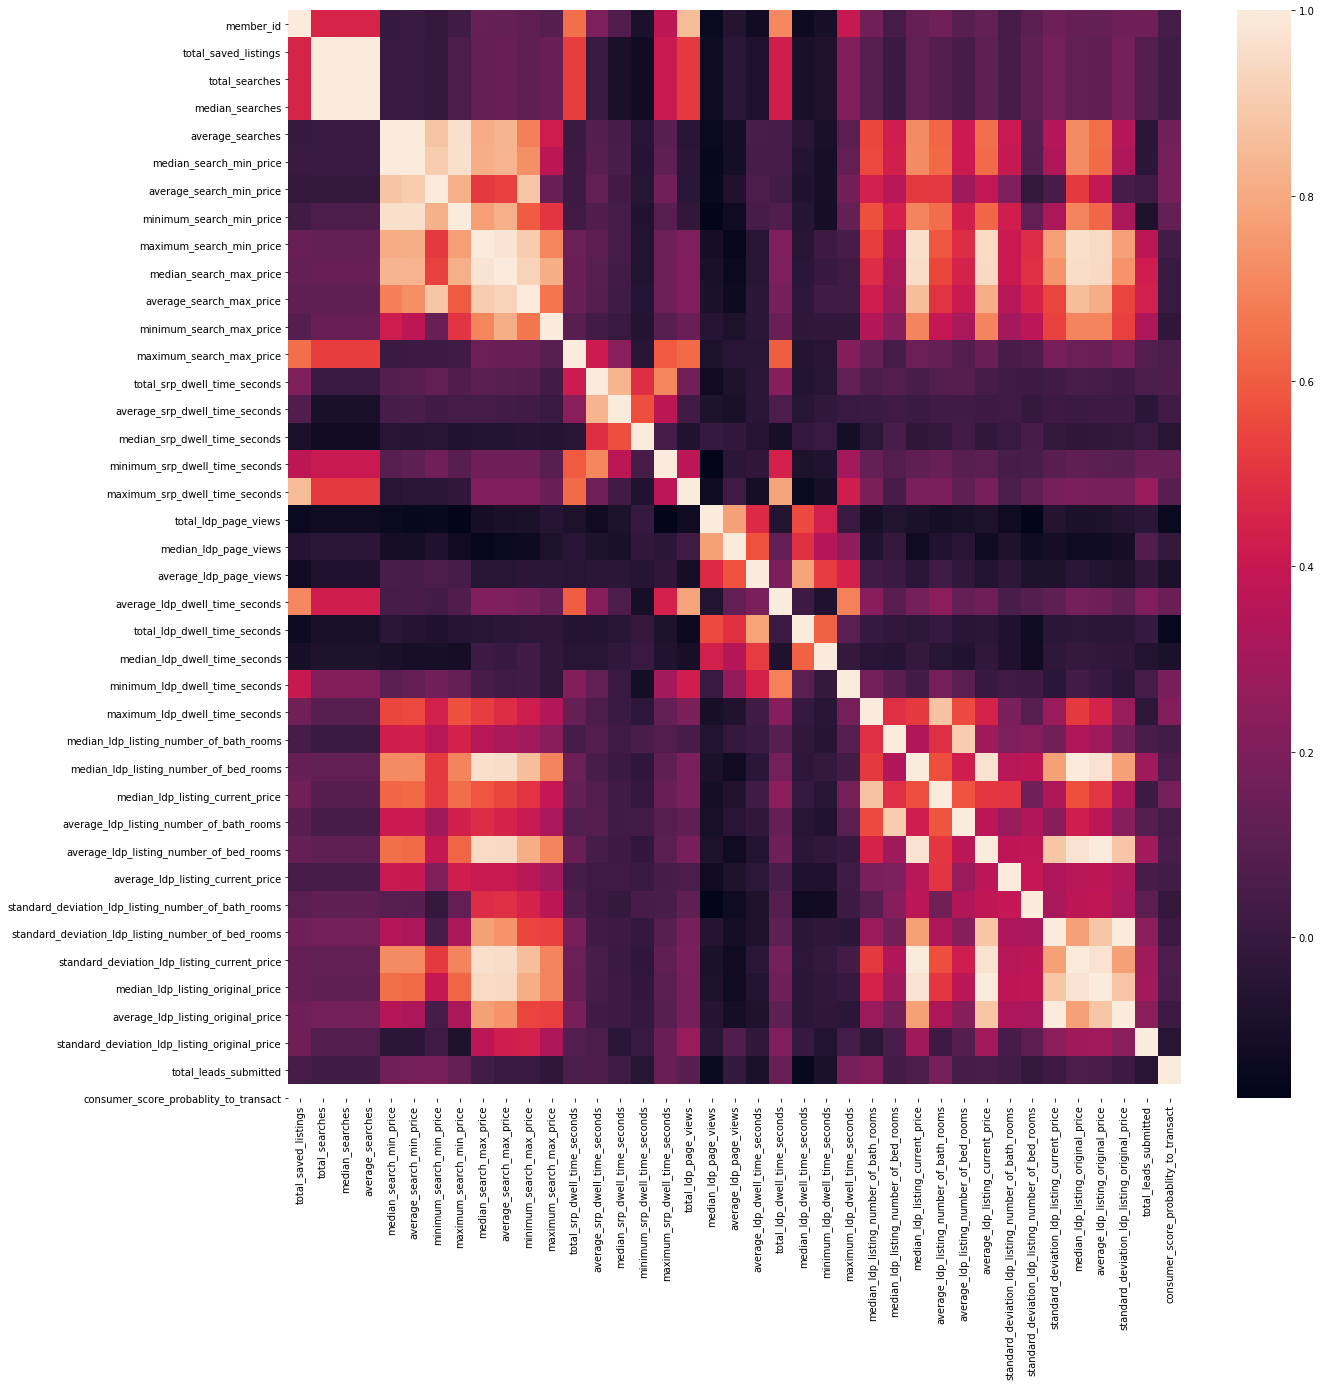

In [13]:
df_for_sale_007_corr = df_for_sale_007.corr()
pyplot.figure(figsize=(20, 20))
sns.heatmap(df_for_sale_007_corr, xticklabels=df_for_sale_007_corr.columns, yticklabels=df_for_sale_007.columns)

In [14]:
res = df_for_sale_007['total_leads_submitted'].corr(df_for_sale_007['consumer_score_probablity_to_transact'])
print(" correlation between lead_submition to consumer score : {}".format(str(res)))

 correlation between lead_submition to consumer score : -0.04813561907361536


In [15]:
df_for_sale_007.to_csv("filtered_intr_lead_trans_007.csv")